In [1]:
%run imports.ipynb

In [2]:
reports = glob.glob('/data/project/SNUH_DNMT3A/result/DBGAP-ERRBS-01/02_bismark/*/*_report.txt')
len(reports)

108

In [7]:
meta = pd.read_csv('source_data/li2016_variant_calls.csv')

In [3]:
with open(reports[0]) as inFile:
    lines = list(l.strip() for l in inFile.readlines())

In [4]:
def get_methylated_chg(lines):
    l = lines[-16]
    return int(l.split('\t')[1])

def get_methylated_chh(lines):
    l = lines[-15]
    return int(l.split('\t')[1])

def get_unmethylated_chg(lines):
    l = lines[-11]
    return int(l.split('\t')[1])

def get_unmethylated_chh(lines):
    l = lines[-10]
    return int(l.split('\t')[1])

def get_bisulfite_conversion_rate(lines):
    m_chg = get_methylated_chg(lines)
    m_chh = get_methylated_chh(lines)
    u_chg = get_unmethylated_chg(lines)
    u_chh = get_unmethylated_chh(lines)
    
    return 1 - (m_chg + m_chh) / (u_chg + u_chh + m_chg + m_chh)

In [9]:
data = defaultdict(list)

for f in reports:
    run = os.path.basename(f).split('.')[0]
    with open(f) as inFile:
        lines = [l.strip() for l in inFile.readlines()]
        
    bisulfite_conversion_rate = get_bisulfite_conversion_rate(lines)
    
    data['run'].append(run)
    data['bisulfite_conversion_rate'].append(bisulfite_conversion_rate)
    
data = pd.DataFrame(data).merge(meta, left_on='run', right_on='run_rrbs', how='outer')

In [11]:
data[['run', 'name', 'status', 'bisulfite_conversion_rate']].to_csv('source_data/li2016_bisulfite_conversion_rate.csv', index=False)

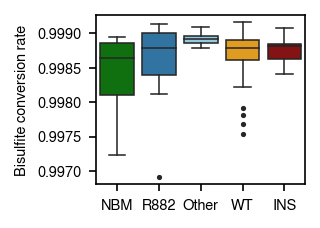

In [16]:
data = pd.read_csv('source_data/li2016_bisulfite_conversion_rate.csv')

fig = plt.figure(figsize=(1.8, 1.5))
ax = fig.add_subplot(111)


order = ['NBM', 'R882', 'Other', 'WT', 'INS']
palette = ['g', 'C0', 'skyblue', 'orange', '#990000']
sns.boxplot(data=data, x='status', y='bisulfite_conversion_rate', order=order, palette=palette, flierprops={'marker': '.'}, fliersize=3, ax=ax)

ax.set_xlabel('')
ax.set_ylabel('Bisulfite conversion rate')

save_figures('source_data_figures/bisulfite_conversion_rate/li2016')

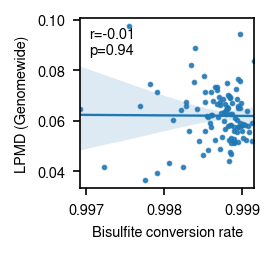

In [22]:
data = pd.read_csv('source_data/li2016_bisulfite_conversion_rate.csv')
lpmd = pd.read_csv('source_data/li2016_genomewide_lpmd.csv').groupby('run_rrbs').agg({'n_concordant': 'sum', 'n_discordant': 'sum'}).reset_index()
lpmd['lpmd'] = lpmd.n_discordant / (lpmd.n_concordant + lpmd.n_discordant)

data = data.merge(lpmd, left_on='run', right_on='run_rrbs')

from scipy.stats import pearsonr

fig = plt.figure(figsize=(1.5, 1.5))
ax = fig.add_subplot(111)

# data.plot.scatter(x='bisulfite_conversion_rate', y='lpmd', ax=ax)
sns.regplot(data=data, x='bisulfite_conversion_rate', y='lpmd', scatter_kws={'s': 3})

r, p = pearsonr(data.bisulfite_conversion_rate, data.lpmd)
ax.text(0.05, 0.95, f'r={r:.2f}\np={p:.2f}', transform=ax.transAxes, ha='left', va='top')

ax.set_xlabel('Bisulfite conversion rate')
ax.set_ylabel('LPMD (Genomewide)')

save_figures('source_data_figures/bisulfite_conversion_rate/li2016_scatter')